In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import warnings
import joblib, pickle, os, re
import datetime
from datetime import datetime
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, TargetEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, 
                            VotingClassifier)
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import KernelPCA, PCA
from sklearn.tree import (DecisionTreeClassifier, ExtraTreeClassifier, plot_tree)
import sys
import dataviz
import plotly.graph_objs as go
import plotly.io as pio
import plotly.subplots as make_subplots
%matplotlib inline
pd.set_option('display.max_columns',None)
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('paper')

warnings.filterwarnings(action='ignore')


## Objectif : 
 * Explorez les données pour chercher les plus grandes corrélation avec l'octroi ou non de crédit.
 * Développer un modèle de prédiction de scoring crédit
 * Créer un dockerfile pour le déploiement 
 * Héberger le code sur github ou gitlab.
 * Créer un tableau de bord interactif via Power BI ou Loocker Studio pour visualiser les résultats du modèle.  

### Données 
[German Credit Data](https://www.kaggle.com/code/mathchi/credit-risk-evaluation/notebook)

## Importing the data

In [3]:

test = pd.read_csv('/home/dona-erick/Test_Technique_DataBeez/German_Data_Credit/Test/german_credit_data.csv')
train= pd.read_csv('/home/dona-erick/Test_Technique_DataBeez/German_Data_Credit/Train/german_credit_data (1).csv')

In [4]:
train.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
test.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## Exploratory Data Analysis

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,499.500,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,35.546,11.375469,19.0,27.00,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.00,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.50,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0


In [9]:
columm_drop = ['Unnamed: 0']
train = train.drop(columns=columm_drop, axis = 1)
test=test.drop(columns =columm_drop, axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [10]:
train.dtypes, train.duplicated().sum(), train.columns

(Age                  int64
 Sex                 object
 Job                  int64
 Housing             object
 Saving accounts     object
 Checking account    object
 Credit amount        int64
 Duration             int64
 Purpose             object
 Risk                object
 dtype: object,
 np.int64(0),
 Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
        'Credit amount', 'Duration', 'Purpose', 'Risk'],
       dtype='object'))

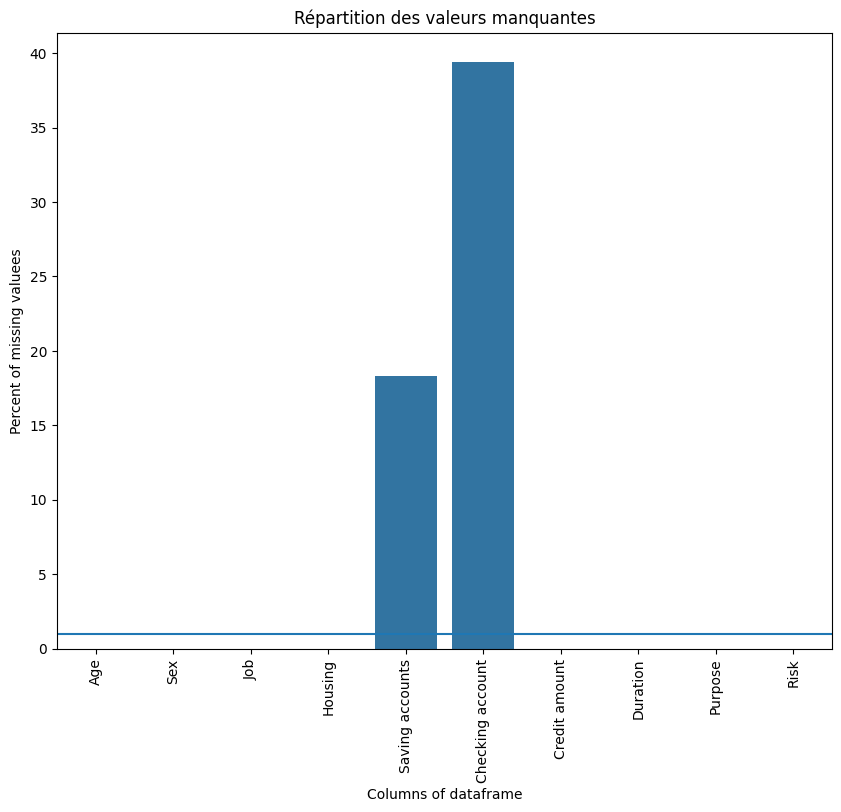

In [18]:
## identification des valeurs manquantes
missing_values = train.isnull().sum()
ratio_missing = (missing_values /train.shape[0])*100
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_values.index, y = ratio_missing.values)
plt.title("Répartition des valeurs manquantes")
plt.xticks(rotation=90)
plt.xlabel('Columns of dataframe')
plt.ylabel("Percent of missing valuees")
plt.axhline(y=1.0, xmax=1,xmin=-1)
#plt.ylim(top=3)
plt.show()

In [17]:
ratio_missing

Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
Risk                 0.0
dtype: float64

####  1-) Analyse univariée

Sex


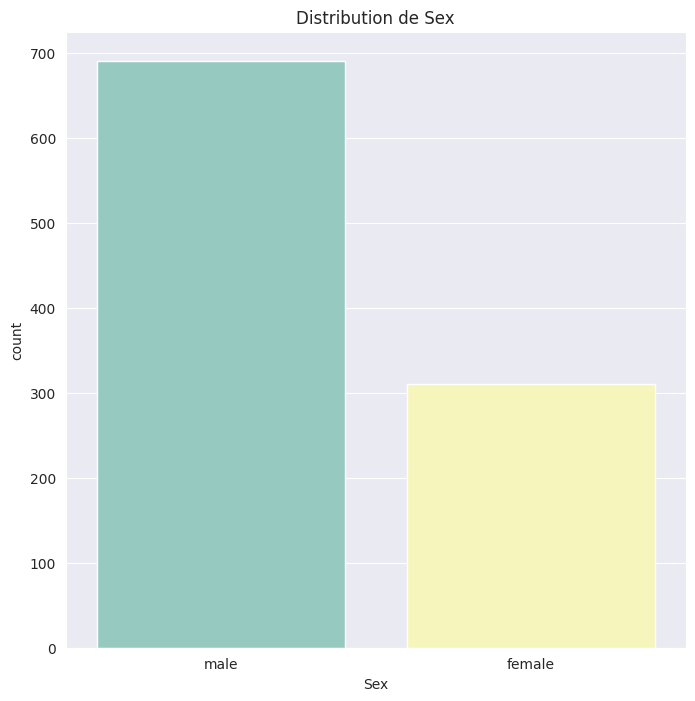

Housing


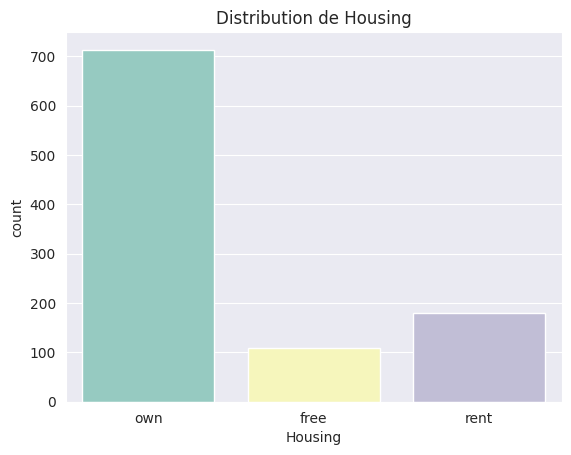

Saving accounts


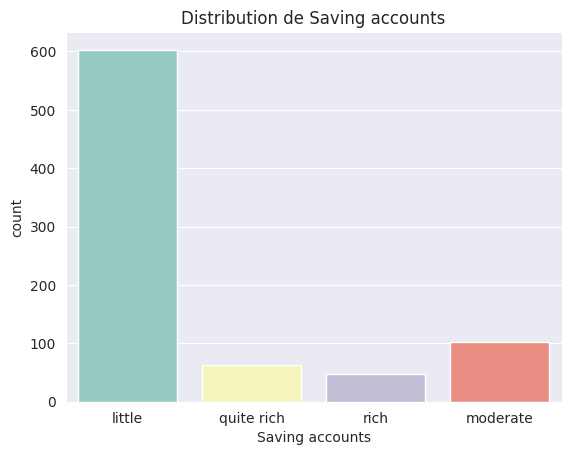

Checking account


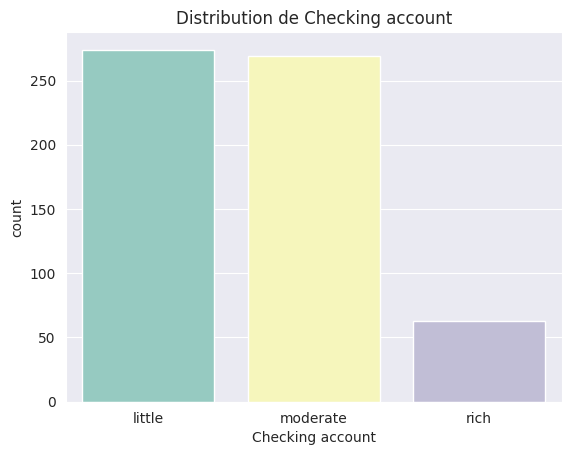

Purpose


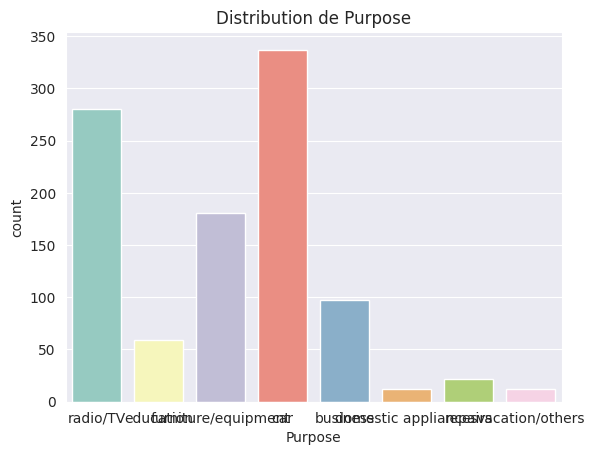

Risk


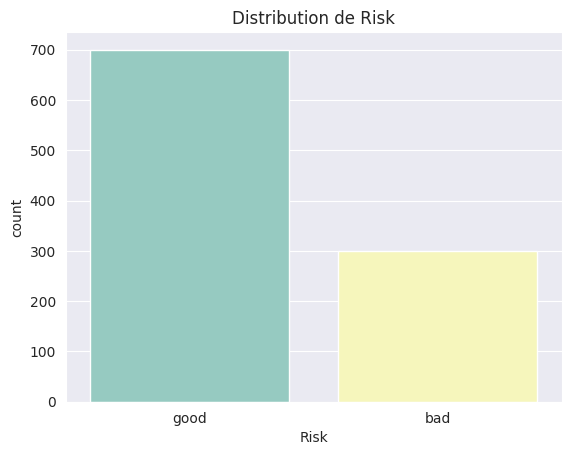

In [20]:
numerical_features = train.select_dtypes(exclude ='object')
categorical_features = train.select_dtypes(include='object')
sns.set_style(style='darkgrid')
plt.figure(figsize=(8, 8))
for var in categorical_features.columns:
    print(var)
    sns.countplot(data =train,x=var, palette='Set3')
    plt.title(f"Distribution de {var}")
    plt.xlabel(f'{var}')
    plt.show()

In [32]:
target_count = train['Risk'].value_counts().reset_index()

fig=go.Figure(go.Bar(
    x=target_count['Risk'], y=target_count['count'], text=target_count['Risk'], #marker={'color': target_count['Risk']},
    textposition='outside')
            )
fig.update_layout(title_text = 'Countplot of Target', xaxis_title ='Risk' , yaxis_title ='count')
fig.show()

In [33]:

## Countplot of sex
sex_count = train['Sex'].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Sex'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Sex', xaxis_title='SEx',yaxis_title='Count')
fig.show()

## countplot of purpose
sex_count = train["Purpose"].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Purpose'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Purpose', xaxis_title='Purpose',yaxis_title='Count')
fig.show()

## countplot of Cjecking account
sex_count = train["Checking account"].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Checking account'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Checking account', xaxis_title='Checking account',yaxis_title='Count')
fig.show()

## countplot fo housing
sex_count = train["Housing"].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Housing'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Housing', xaxis_title='Housing',yaxis_title='Count')
fig.show()

## countplot of saving amounts
sex_count = train['Saving accounts'].value_counts().reset_index()
fig = go.Figure(go.Bar(
    x = sex_count['Saving accounts'], y =sex_count['count'], text=sex_count['count'],
    textposition='outside'))
fig.update_layout(title_text = 'COuntplot of Saving accounts', xaxis_title='Saving accounts',yaxis_title='Count')
fig.show()